Devon du Toit, dutoitdevon@gmail.com

<h1>2 Qubit Variable Quantum Eigensolver</h1>

<h3>Decomposing 2 qubit Hamiltonian into Pauli terms</h3>

A 4x4 (2 qubit) Hamiltonian matrix, $H$ may be decomposed into the sum and tensor products of its Pauli-terms. The four Pauli-terms under consideration are:

\begin{equation}
\sigma_{I}=\begin{bmatrix}
1&0\\
0&1
\end{bmatrix},
\sigma_{x}=\begin{bmatrix}
0&1\\
1&0
\end{bmatrix},
\sigma_{y}=\begin{bmatrix}
0&-i\\
i&0
\end{bmatrix},
\sigma_{z}=\begin{bmatrix}
1&0\\
0&-1
\end{bmatrix}
\end{equation}

We may find the exact combination of these terms to construct the Hamiltonian using the Hillbert-Schmidt Inner Product of two matrices:

\begin{equation}
H=\sum_{i=1,x,y,z}\sum_{j=1,x,y,z}\frac{1}{4}tr[(\sigma_{i} \otimes \sigma_{j})H](\sigma_{i} \otimes \sigma_{j})
\end{equation}

In [1]:
import numpy as np

#Define the Hamiltonian Matrix
H = np.matrix('1 0 0 0; 0 0 -1 0; 0 -1 0 0; 0 0 0 1')

def decompose(H):
    #define the four Pauli-matrices in a dictionary:
    pauli_g = [np.matrix('1 0; 0 1'), #Identity
               np.matrix('0 1; 1 0'), #Sigma X
               np.matrix('0 -1j; 1j 0'), #Sigma Y, 1j = imaginary (i)
               np.matrix('1 0; 0 -1') #Sigma Z
              ]
    
    #Naming of Pauli-matrices for usability
    sig_names = ['I', 'sig_x', 'sig_y', 'sig_z']
    
    #Applying the Summation of i and j for all combinations of 1,x,y,z. 
    for i in range(4):
        for j in range(4):
            #Improving Readability of output
            name = sig_names[i] + '⊗' +sig_names[j] 
            #Calculate  a_i,j via function Hill_Sch. np.kron = Kronecker product
            a_ij = 0.25 * Hill_Sch(np.kron(pauli_g[i], pauli_g[j]), H)
            
            #If the Hillbert-Schmidt Product doesn't reduce to 0
            if a_ij != 0.0:
                print(value(a_ij),'*', name)
                
   
#Conversion of the complex number into a string
def value(c):
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)
            
#Determine Hillbert Schmidt Product of two matrices
def Hill_Sch(Matrix_1, Matrix_2):
    #Quantum method of multiplying matrices |ψ1> and |ψ2>: <ψ1*|ψ2> for <ψ1*| the complex conjugate of |ψ1> 
    return (np.dot(Matrix_1.conjugate().transpose(), Matrix_2)).trace()

#Run script
decompose(H)

0.5 * I⊗I
-0.5 * sig_x⊗sig_x
-0.5 * sig_y⊗sig_y
0.5 * sig_z⊗sig_z


Given input:

\begin{equation}
H=\begin{bmatrix}
1 &0 &0 &0\\
0 &0 &-1 &0\\
0 &-1 &0 &0\\
0 &0 &0 &1
\end{bmatrix}
\end{equation}

We find the deconstruction into Pauli terms to be:

\begin{equation}
H= \frac{1}{2} I \otimes I - \frac{1}{2} X \otimes X -\frac{1}{2} Y \otimes Y + \frac{1}{2} Z \otimes Z
\end{equation}

We may thus simplify our code by only looking at tensor products of the same Pauli-terms (XX, YY etc.)

<h3>Finding an Ansatz</h3>

We need an ansatz that can access all the possible states, yet isn't overly complicated and too resource intensive. For simplicity, I selected an existing ansatz performing well under similar circumstances (2-qubit vqe), found here: http://www.warrenalphonso.com/qc/hubbard .

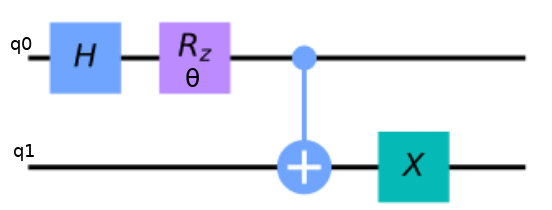

<h3>Ensuring measurements in the Z-basis</h3>
    
After our phase preperation, we need to ensure our phases are Z-basis measurable, therefore we need to apply rotations unique to each phase:

- For X, the gate RY(−π/2) is applied.
- For Y, RX(π/2) is applied.
- For Z, no gate is applied.

Using these criteria, we may now construct our quantum circuits.

In [2]:
from qiskit import *
simulator = Aer.get_backend('qasm_simulator')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

In [4]:
#define empty arrays to store measurements of Hamiltonian terms XX, YY, ZZ (no need for II as that will equal 1)
resultx = []
resulty = []
resultz = []

#We construct a new circuit for each change in ansatz perimeter (from -2pi to 2pi).
for i in np.arange(-(9/4)*np.pi, (9/4)*np.pi, np.pi/4):
    circuit = QuantumCircuit(qr, cr)
    
    #Ansatz
    circuit.h(qr[0])
    circuit.rz(i, qr[0])
    circuit.cx(qr[0], qr[1])
    circuit.x(qr[1])
    
    #XX Hamiltonian term
    circuitx = circuit.copy()
    #Ensureing Z-basis measurements for X
    circuitx.ry(-np.pi/2, qr[0])
    circuitx.ry(-np.pi/2, qr[1])
    #Measurements
    circuitx.measure(qr[0], cr[0])
    circuitx.measure(qr[1], cr[1])
    #Store counts results for XX
    jobx = execute(circuitx, backend = simulator)
    result = jobx.result()
    countsx = result.get_counts()
    resultx.append(countsx)
    
    #YY Hamiltonian term
    circuity = circuit.copy()
    #Ensureing Z-basis measurements for Y
    circuity.rx(np.pi/2, qr[0])
    circuity.rx(np.pi/2, qr[1])
    #Measurements
    circuity.measure(qr[0], cr[0])
    circuity.measure(qr[1], cr[1])
    #Store counts results for Y
    joby = execute(circuity, backend = simulator)
    result = joby.result()
    countsy = result.get_counts()
    resulty.append(countsy)
    
    #ZZ Hamiltonian term
    circuitz = circuit.copy()
    #Measurements
    circuitz.measure(qr[0], cr[0])
    circuitz.measure(qr[1], cr[1])
    #Store counts results for Z
    jobz = execute(circuitz, backend = simulator)
    result = jobz.result()
    countsz = result.get_counts()
    resultz.append(countsz)

In [5]:
#Define empty array to store XX expectation values
expectx = []

#Fill empty states with null values for XX
for n in resultx:
    if '00' not in n:
        n['00']=0
            
    if '01' not in n:
        n['01']=0

    if '10' not in n:
        n['10']=0

    if '11' not in n:
        n['11']=0

    expec_val = (n['00']-n['01']-n['10']+n['11'])/1024
    expectx.append(expec_val)
    
#Define empty array to store YY expectation values
expecty = []

#Fill empty states with null values for YY
for n in resulty:
    if '00' not in n:
        n['00']=0
            
    if '01' not in n:
        n['01']=0

    if '10' not in n:
        n['10']=0

    if '11' not in n:
        n['11']=0

    expec_val = (n['00']-n['01']-n['10']+n['11'])/1024
    expecty.append(expec_val)
    
    #Define empty array to store ZZ expectation values
expectz = []

#Fill empty states with null values for ZZ
for n in resultz:
    if '00' not in n:
        n['00']=0
            
    if '01' not in n:
        n['01']=0

    if '10' not in n:
        n['10']=0

    if '11' not in n:
        n['11']=0

    expec_val = (n['00']-n['01']-n['10']+n['11'])/1024
    expectz.append(expec_val)

In [9]:
#define empty array for total expectation value
expect_tot = []

#Apply H = 0.5II+0.5ZZ-0.5XX-0.5YY and store for each value from -2pi to 2pi in intervals of pi/4 (18 times)
for m in range(18):
    expect_tot.append(-0.5*expectx[m]-0.5*expecty[m]+0.5*expectz[m]+0.5)
    
print(expect_tot)

[-0.7119140625, -1.0, -0.7001953125, 0.0244140625, 0.681640625, 1.0, 0.720703125, 0.0146484375, -0.6923828125, -1.0, -0.7275390625, -0.037109375, 0.7109375, 1.0, 0.6962890625, 0.0166015625, -0.720703125, -1.0]


In [7]:
#Define x values for a matplot graph for -2pi to 2pi in steps pi/4
p = np.linspace(-2*np.pi,2*np.pi,18)

Text(0, 0.5, 'Eigenvalue Estimate')

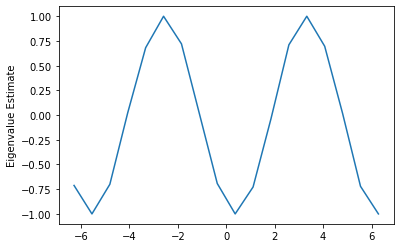

In [14]:
plt.plot(p, expect_tot)
plt.ylabel("Eigenvalue Estimate")

<h3>Lowest Eigenvalue Estimation</h3>

As can been seen from our graph and list of expectation values, the lowest eigenvalue seems to be -1. We may verify this with numpy.linalg.eig():

In [10]:
np.linalg.eig(H)

(array([ 1., -1.,  1.,  1.]),
 matrix([[ 0.        ,  0.        ,  1.        ,  0.        ],
         [-0.70710678,  0.70710678,  0.        ,  0.        ],
         [ 0.70710678,  0.70710678,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]))

We thus see that the eigenvalues are +/- 1. We may conclude that our quantum circuit simualtor does indeed give an accurate estimation.